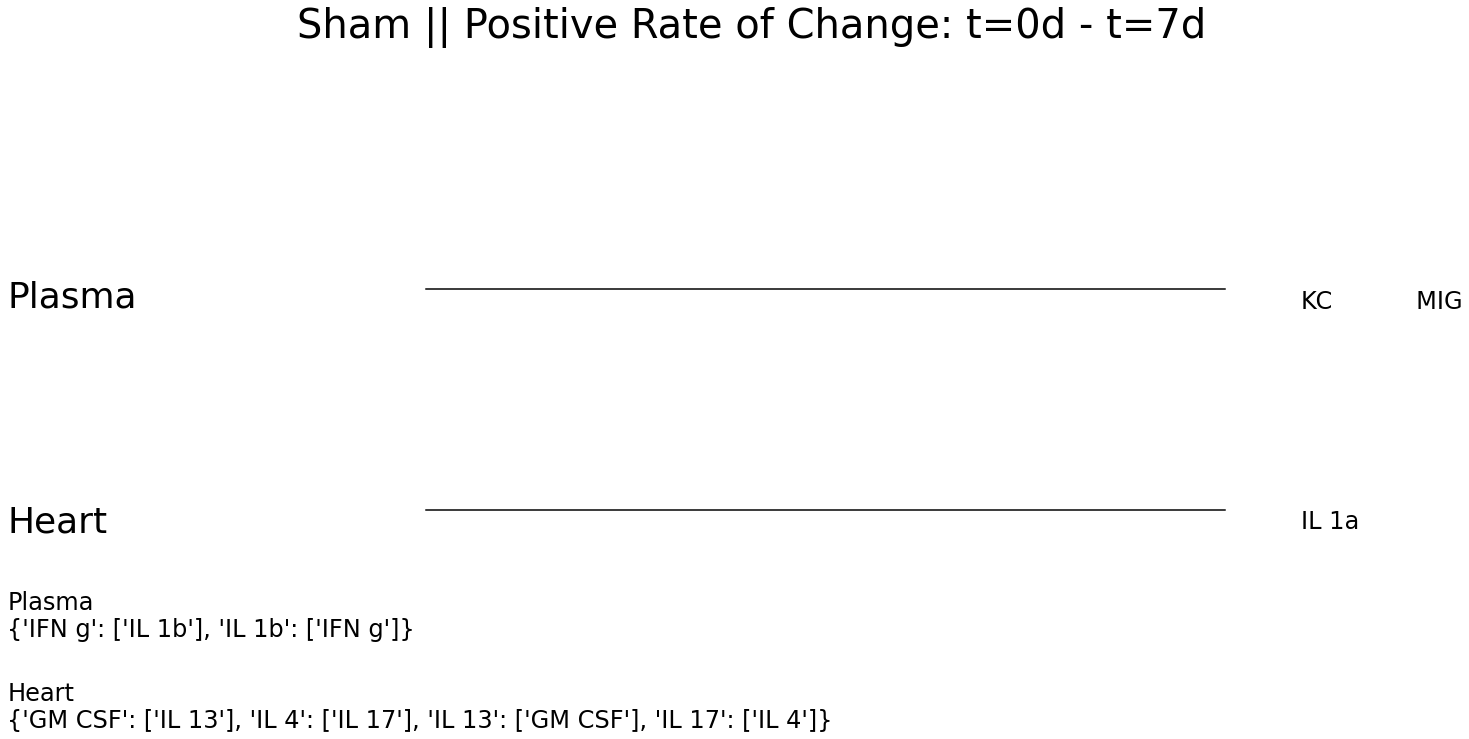

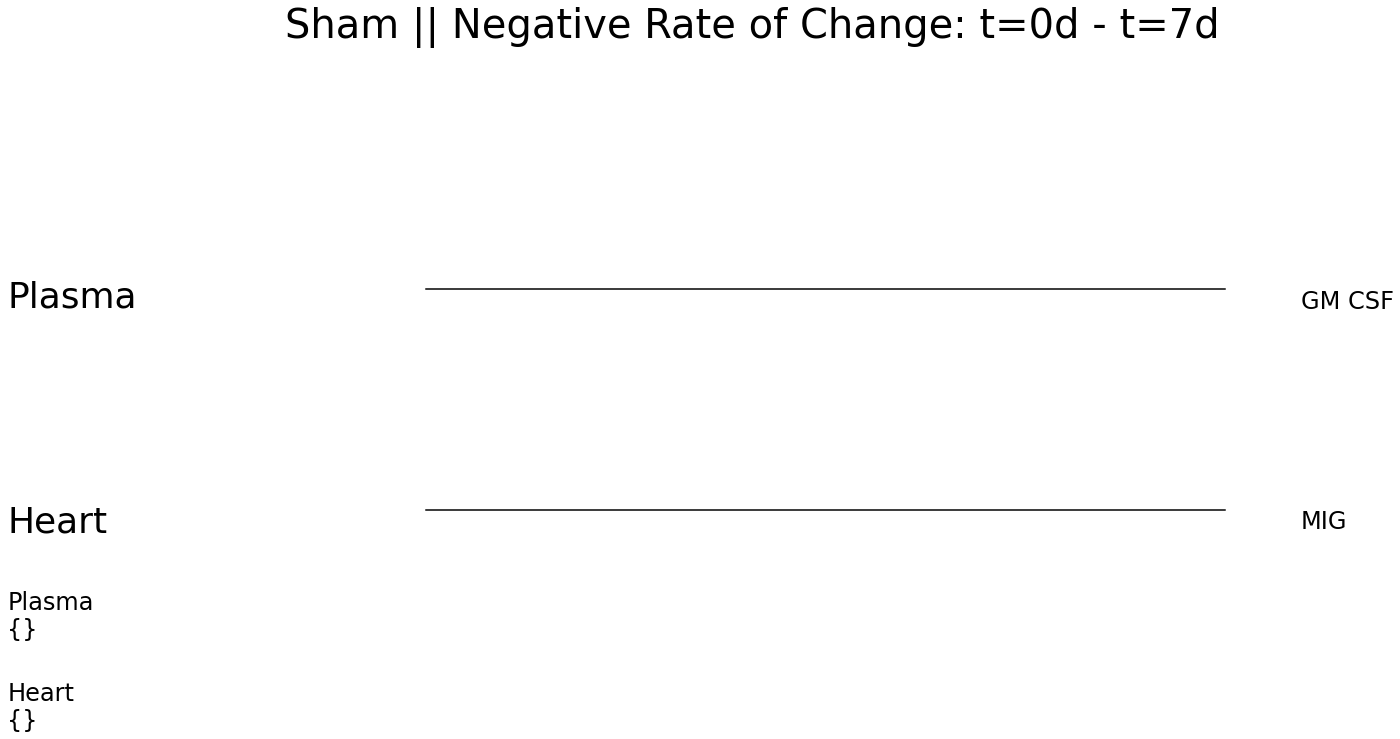

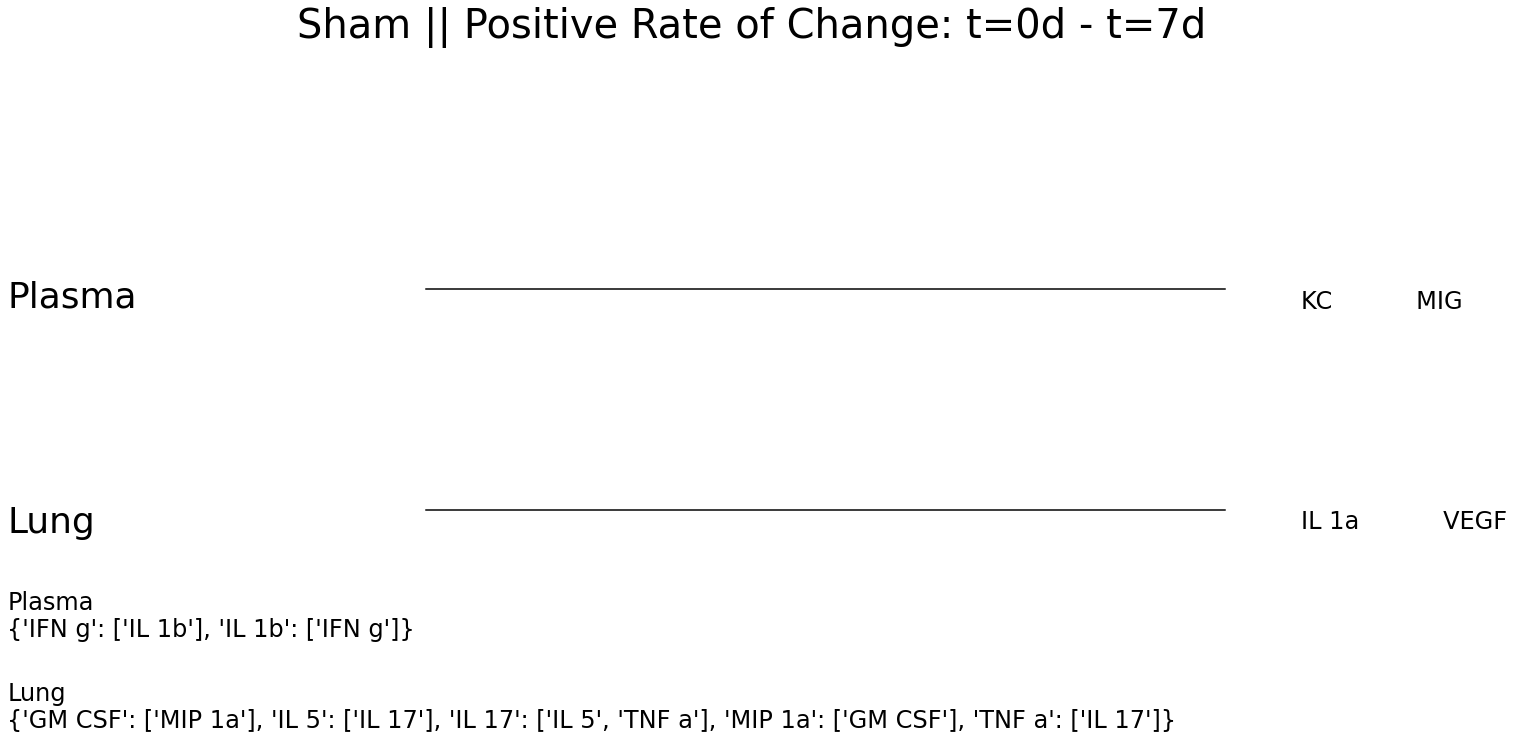

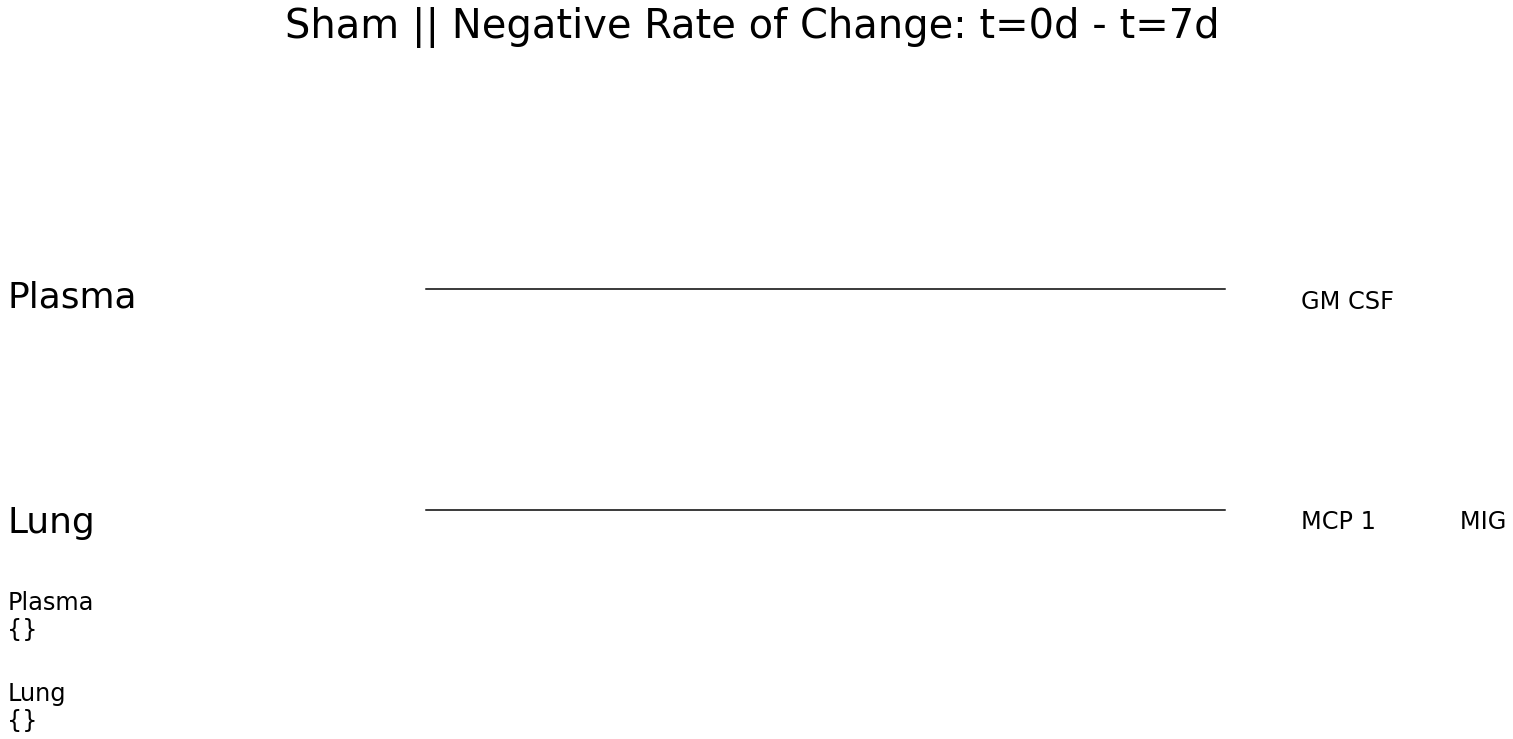

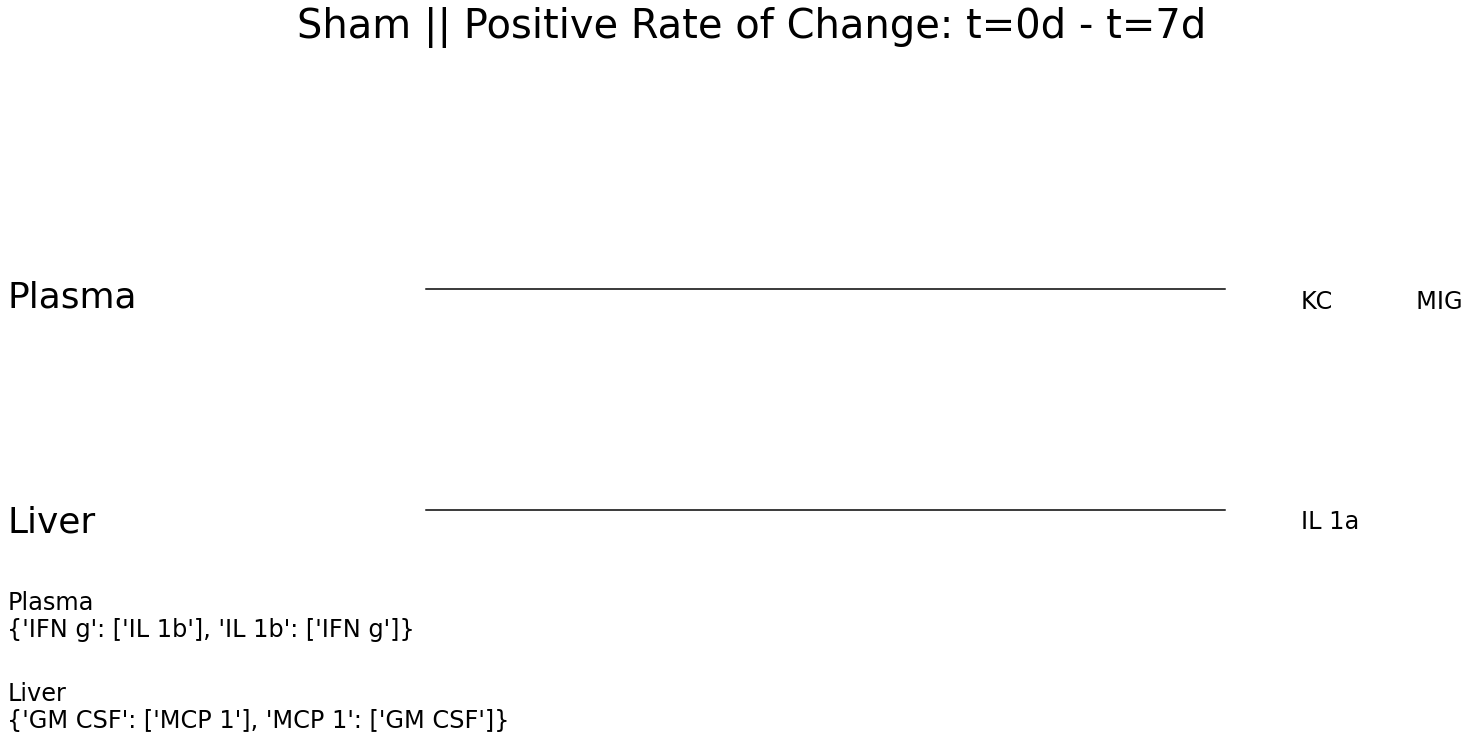

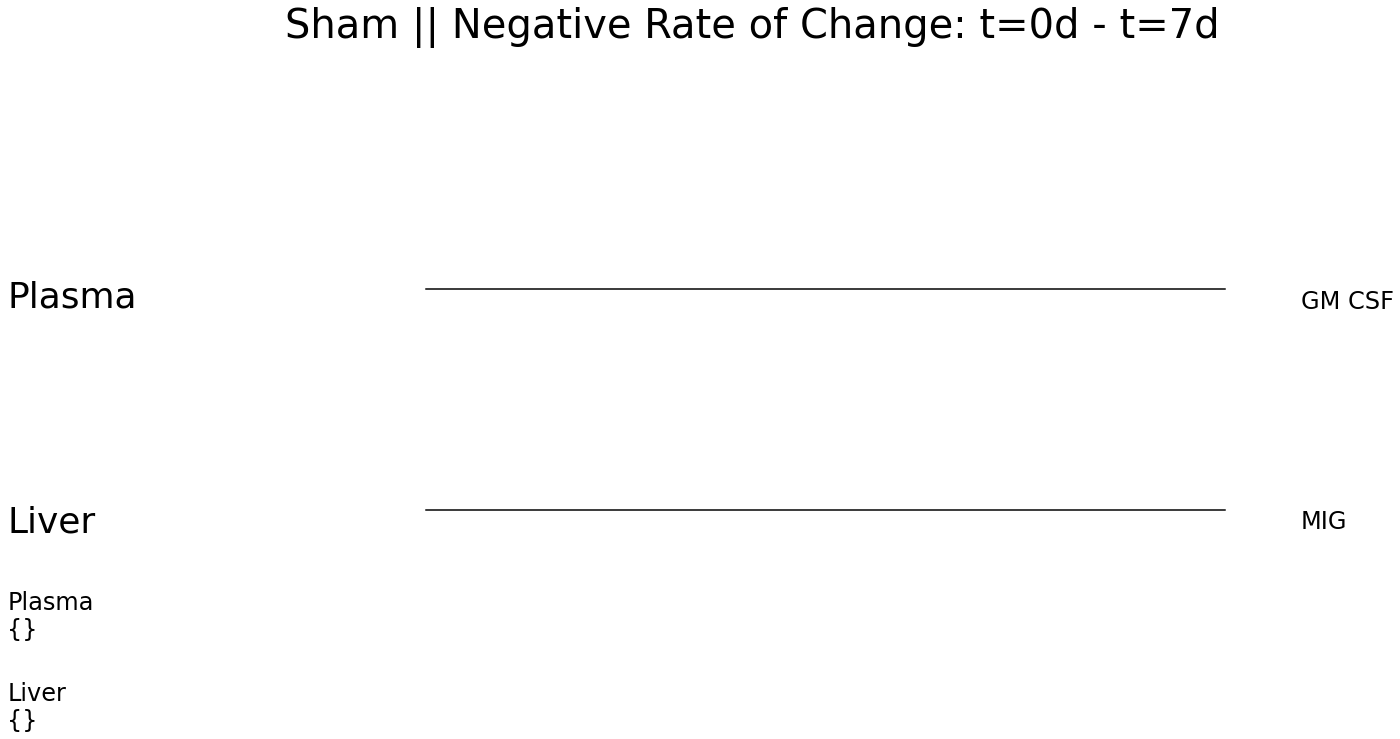

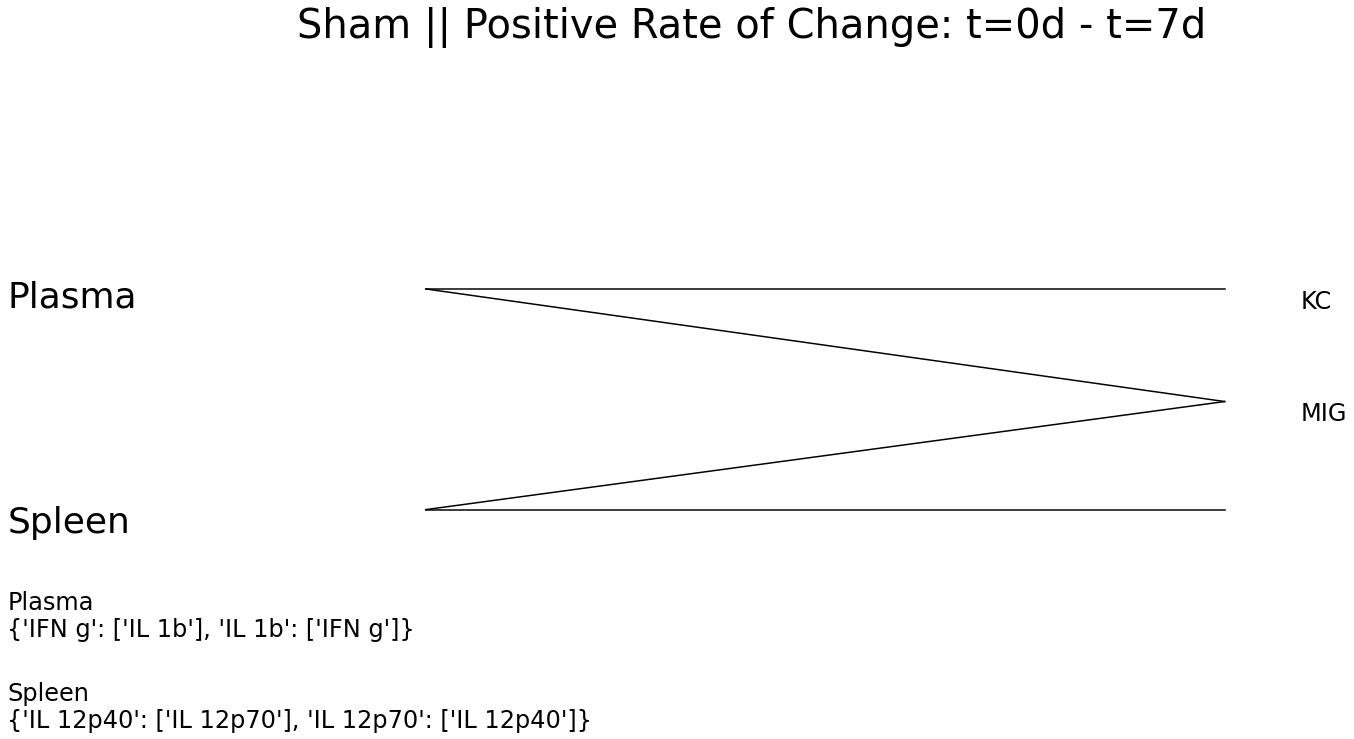

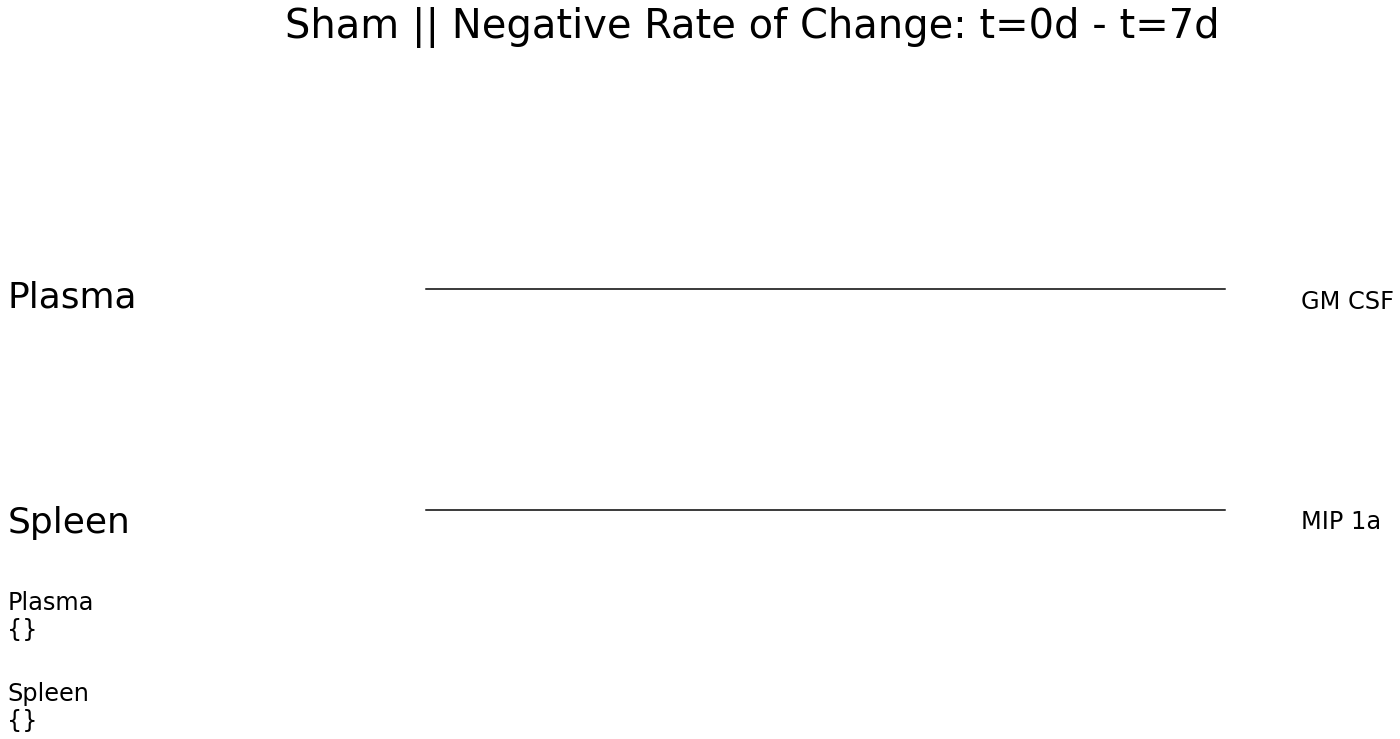

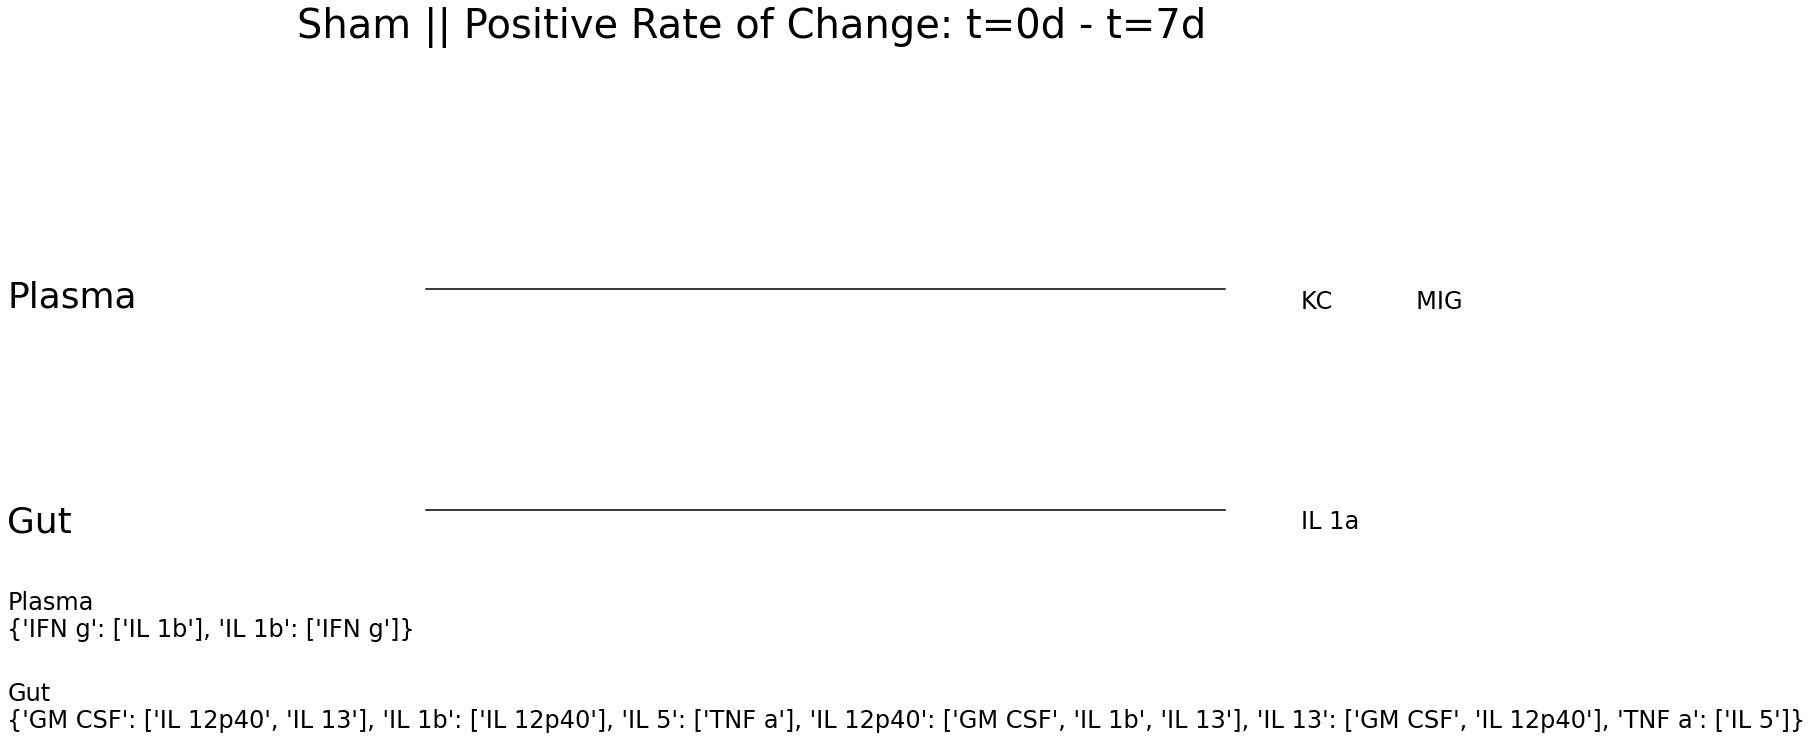

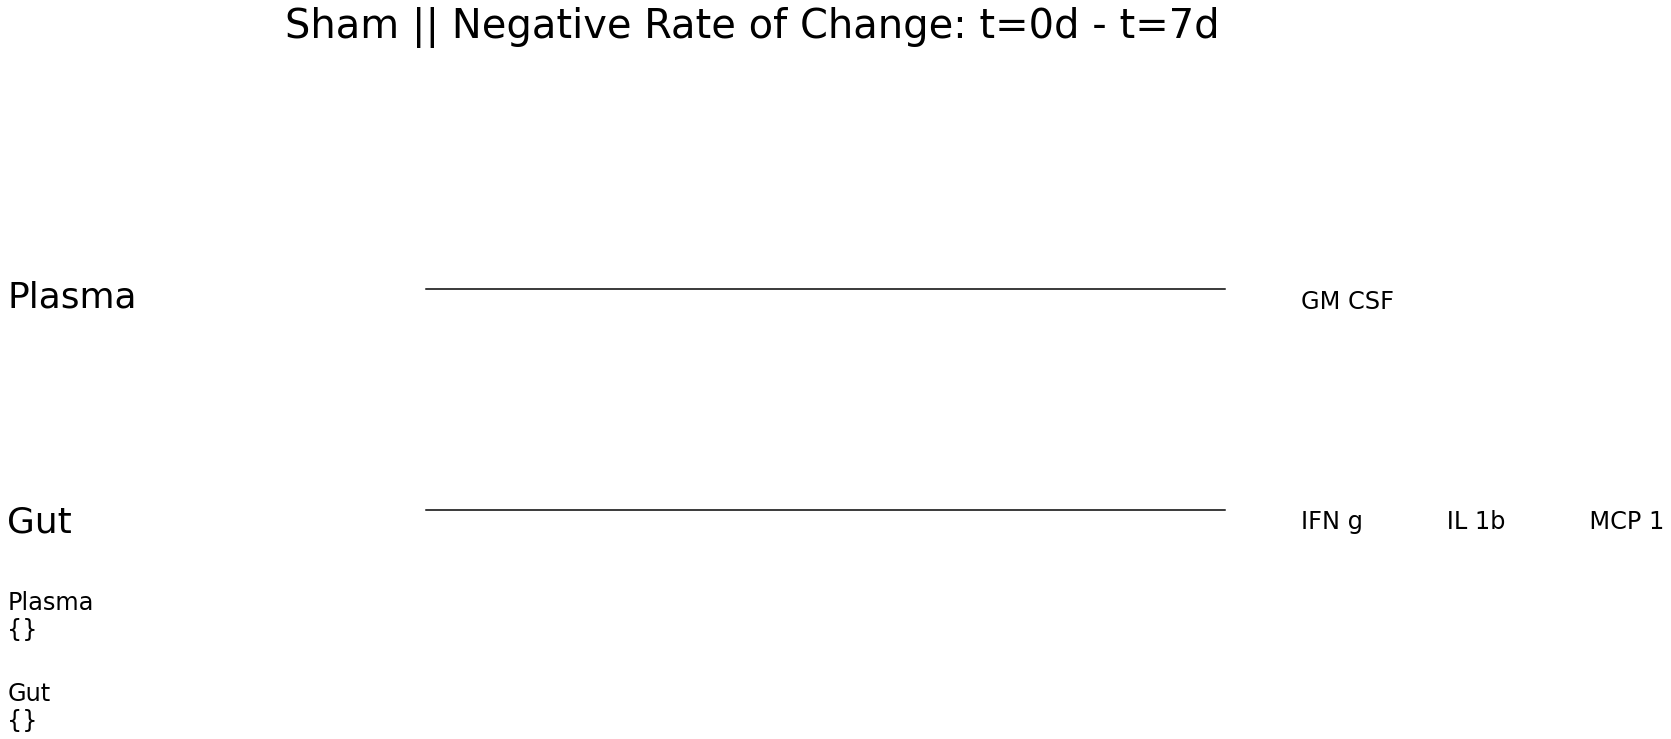

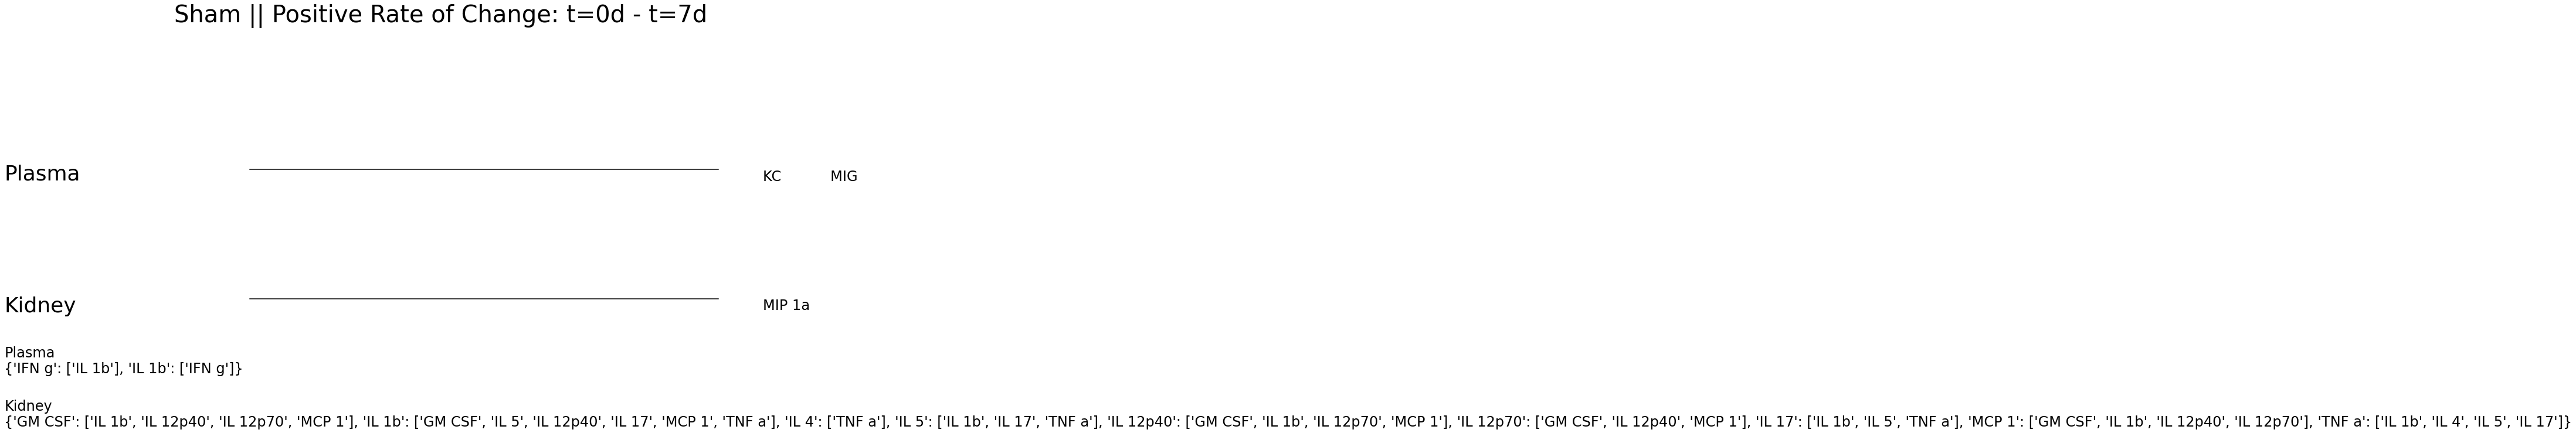

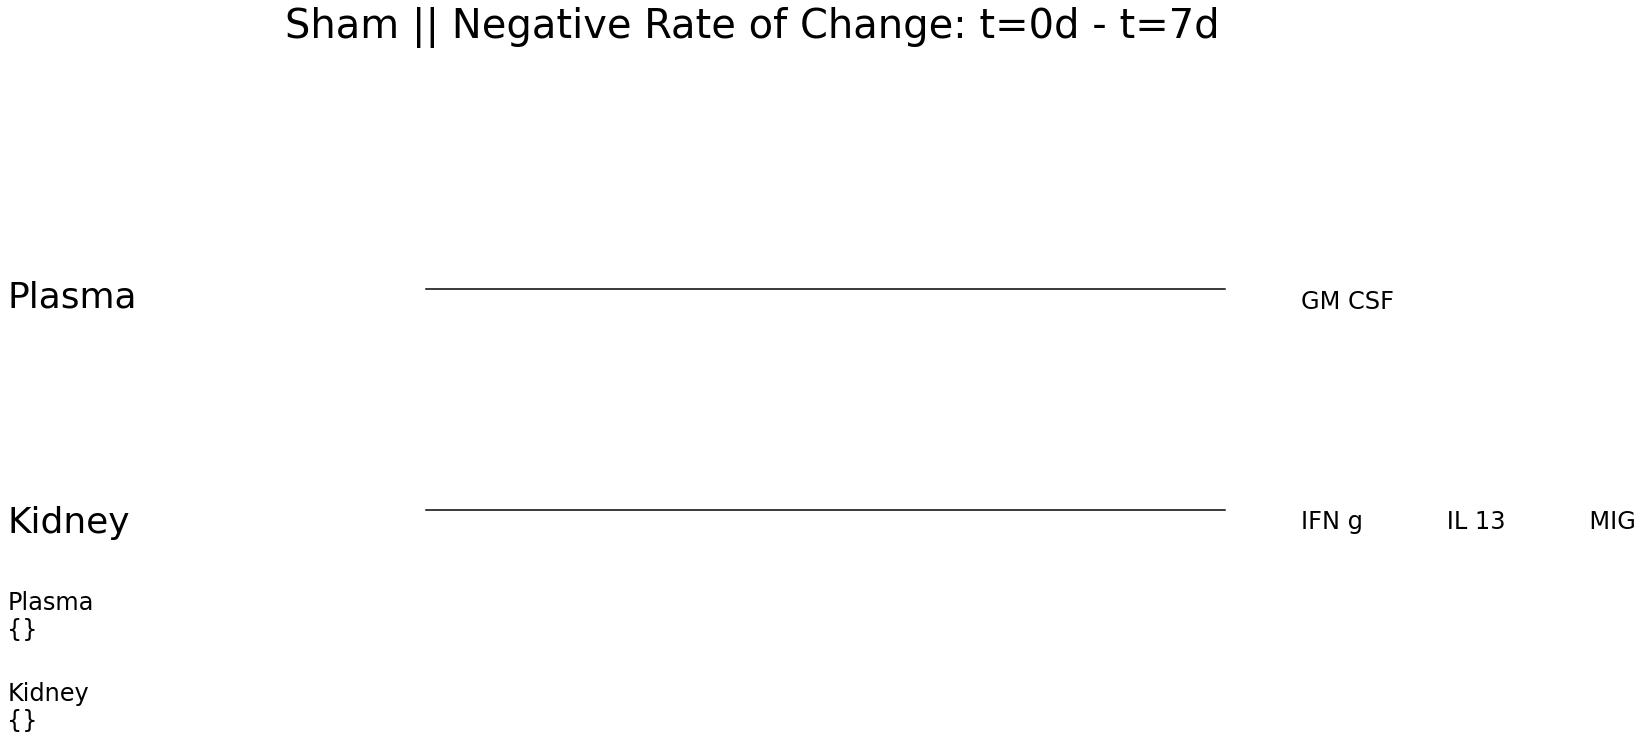

In [8]:
import sys
import os
import pandas
from pandas import ExcelWriter
import matplotlib
from matplotlib import pyplot as plt
import statistics
import math
import scipy
from scipy import stats
import numpy as np


#AUTHOR: ASHTI M. SHAH
#MENTORS: DR. YORAM VODOVOTZ AND DR. RUBEN ZAMORA
#DATE: January, 2023

"Import data"
raw_data = pandas.DataFrame()
raw_data = pandas.read_csv('raw_data_sham_vgx_no_outliers.csv')
cytokines = list(raw_data.columns.values)[4:] #list of all cytokines

"Organize data by condition"

all_data_Baseline = raw_data.loc[raw_data['Condition'] == 'Baseline']
all_data_Sham = pandas.concat([all_data_Baseline,raw_data.loc[raw_data['Condition'] == 'Sham']])
all_data_Vgx = pandas.concat([all_data_Baseline, raw_data.loc[raw_data['Condition'] == 'Vgx']])

#Function to get the correlation of each inflammatory mediator in a single organ
#with TIME based on RATE OF CHANGE
def get_rate_of_change_inflammatory_mediator_and_TIME(tissue_rel_data, time_int):
    #tissue_rel_data: rel_data_cur_organ; table of the relevant data from two time points from a single organ 
    #time_int: int array of consective time points. ex [1, 3]
    
    "Get the data frames of data for each time point"
    time_1 = tissue_rel_data.loc[tissue_rel_data['Condition'] == "Baseline"]
    time_2 = tissue_rel_data.loc[tissue_rel_data['Condition'] != "Baseline"]
    "Get the data frames of just the inflammatory mediators for each time point"
    time1_mediators = time_1.iloc[:,4:]
    time2_mediators = time_2.iloc[:,4:]
    
    cytokines = list(time1_mediators.columns.values) #list of all cytokines

    "Calculate rate of change"
    rate_of_change_table = pandas.DataFrame();
    for c in cytokines:
        x1 = time_int[0]
        x2 = time_int[1]
        "Rate of change is calculated using median cytokine value at each timepoint"
        y1 = time1_mediators[c].median()
        y2 = time2_mediators[c].median()
        "Calculate rate of change, x = time, y = median inflammatory value"
        rate_of_change = (y2-y1)/(x2-x1)
        rate_of_change_table[c] = [rate_of_change]
    return (rate_of_change_table)

#Function to return a list of mediators that are positively correlated with time in a single organ
def get_significant_mediators_withTIME_positive (inflammatory_mediator_rates, num_std_dev):
    #inflammatory_msediator_rates: correlation matrix (1x20) which has the pearson correlation of each inflammatory
    #mediator with itself over a dynamic time interval
    #num_std_dev: number of standard deviations above the mean rate of change at which a cytokine is considered
    #to be significantly increasing
    
    cytokines = list(inflammatory_mediator_rates.columns.values) #list of all cytokines
    pos_mediators = []

    for c in cytokines:
        if inflammatory_mediator_rates[c][0]>0:
            pos_mediators.append(inflammatory_mediator_rates[c][0])
    mean = np.mean(pos_mediators)
    stdev = np.std(pos_mediators)
    threshold = mean + stdev*num_std_dev
    
    significant_pos_mediators = []
    for j in cytokines:
         if inflammatory_mediator_rates[j][0]>threshold:
            significant_pos_mediators.append(j)
    return significant_pos_mediators   

def get_significant_mediators_withTIME_negative (inflammatory_mediator_rates,num_std_dev):
    #inflammatory_msediator_rates: correlation matrix (1x20) which has the pearson correlation of each inflammatory
    #mediator with itself over a dynamic time interval
    #num_std_dev: number of standard deviations below the mean rate of change at which a cytokine is considered
    #to be significantly decreasing
    
    cytokines = list(inflammatory_mediator_rates.columns.values) #list of all cytokines
    neg_mediators = []

    for c in cytokines:
        if inflammatory_mediator_rates[c][0]<0:
            neg_mediators.append(inflammatory_mediator_rates[c][0])
    mean = np.mean(neg_mediators)
    stdev = np.std(neg_mediators)
    threshold = mean - stdev*num_std_dev
    
    significant_neg_mediators = []
    for j in cytokines:
         if inflammatory_mediator_rates[j][0]<threshold:
            significant_neg_mediators.append(j)
    return significant_neg_mediators 

#Function to get the corelation every pair of inflammatory mediators in a single organ across two time points   
def get_correlation_matrix_withMEDIATORS_individual_tissue (tissue_rel_data, time_int):
    #baseline_data: data at t0
    #tissue_rel_data: rel_data_cur_organ; table of the relevant data from two time points from a single organ 
    #time_int: int array of consective time points. ex [1, 3]
    "Get the data frames of data for each time point" 
    time_1 = tissue_rel_data.loc[tissue_rel_data['Condition'] == "Baseline"]
    time_2 = tissue_rel_data.loc[tissue_rel_data['Condition'] != "Baseline"]
   

    "Get the data frames of just the inflammatory mediators for each time point"
    time1_mediators = time_1.iloc[:,4:]
    time2_mediators = time_2.iloc[:,4:]
    
    cytokines = list(time1_mediators.columns.values) #list of all cytokines

    corr_table_all_mediators = pandas.DataFrame(columns=range(len(cytokines)))
    corr_table_all_mediators.columns = cytokines
    "Nested loop in which we correlate x cytokine with all other cytokines"
    for x in cytokines:
        "x: the cytokine that we are correlating all other cytokines with"
        corr_data_x_current_mediator = pandas.DataFrame(time1_mediators[x].append(time2_mediators[x])).reset_index (drop=True)
        correl_with_cur_mediator = pandas.DataFrame()
        for c in cytokines:
            corr_data_y = pandas.DataFrame(time1_mediators[c].append(time2_mediators[c])).reset_index(drop=True)
            correlation_data = pandas.concat([corr_data_x_current_mediator, corr_data_y], axis = 1, ignore_index=True)
            correlation_data.columns = [x,c]
            "to allow a DyNA edge to be drawn, both cytokine X and C must be significantly different than the baseline value"
            "by default, assume that X and C are not correlated"
            correlation_coeff_cur_cytokine = 0 
            pearsons_correl_cur_cytokine = correlation_data.corr(method = 'pearson')
            "Check if X is significantly different from baseline"
            t_test_time2_x = scipy.stats.ttest_ind(time1_mediators[x],time2_mediators[x], nan_policy='omit')
            t_test_time2_c = scipy.stats.ttest_ind(time1_mediators[c],time2_mediators[c], nan_policy='omit')
            if (t_test_time2_x.pvalue <0.05) and (t_test_time2_c.pvalue <0.05):
                correlation_coeff_cur_cytokine = pearsons_correl_cur_cytokine.iloc[0,1]
            correl_with_cur_mediator[c] = [correlation_coeff_cur_cytokine]
        corr_table_all_mediators = pandas.concat([corr_table_all_mediators, correl_with_cur_mediator])
    corr_table_all_mediators.index = cytokines
    return (corr_table_all_mediators)

#Function return a dictionary of significant mediators that are positively correlated with each other
def get_significant_mediators_withEACHOTHER_positive (correl_matrix_with_mediators, threshold):
    #correl_matrix_with_mediators: correlation matrix (27x27) which has the pearson correlation of each inflammatory
    #mediator with every other mediator over a dynamic time interval
    #threshold: minimum pearson correlation, type: float
    cytokines_column = list(correl_matrix_with_mediators.columns.values)
    cytokines_row = list(correl_matrix_with_mediators.index.values) #list of all cytokines
    significant_mediators = {}
    for x in cytokines_column:
        significant_mediators_in_col = []
        for c in cytokines_row:
            cur_correlation = correl_matrix_with_mediators.loc[c,x]
            if math.isnan(cur_correlation)== False:
                if cur_correlation >= threshold and x!=c:
                    significant_mediators_in_col.append(c)
        if len (significant_mediators_in_col) > 0:
                significant_mediators[x] = significant_mediators_in_col
    return significant_mediators
    
#Function return a dictionary of significant mediators that are negatively correlated with each other
def get_significant_mediators_withEACHOTHER_negative (correl_matrix_with_mediators, threshold):
    #correl_matrix_with_mediators: correlation matrix (27x27) which has the pearson correlation of each inflammatory
    #mediator with every other mediator over a dynamic time interval
    #threshold: minimum pearson correlation, type: float
    cytokines_column = list(correl_matrix_with_mediators.columns.values)
    cytokines_row = list(correl_matrix_with_mediators.index.values) #list of all cytokines
    significant_mediators = {}
    for x in cytokines_column:
        significant_mediators_in_col = []
        for c in cytokines_row:
            cur_correlation = correl_matrix_with_mediators.loc[c,x]
            if math.isnan(cur_correlation)== False:
                if cur_correlation <= threshold*-1 and x!=c:
                    significant_mediators_in_col.append(c)
        if len (significant_mediators_in_col) > 0:
                significant_mediators[x] = significant_mediators_in_col
    return significant_mediators

def group_edges_dyHyp (tissue_1, tissue_2, tissue_1_name, tissue_2_name):
    #Tissue_1: significant mediators within plasma
    #Tissue_2: significant mediators within another tissue
    #tissue_1_name: str, tissue1
    #tissue_2_name: str, tissue2
    edges = {tissue_1_name: [], tissue_2_name: [], "{} and {}".format(tissue_1_name, tissue_2_name): []}
    for j in tissue_1:
        if j in tissue_2:
            edges["{} and {}".format(tissue_1_name, tissue_2_name)].append(j)
            tissue_2.remove(j)
        else:
            edges[tissue_1_name].append(j)
    if len (tissue_2) != 0:
        for n in tissue_2:
            edges[tissue_2_name].append(n)
    return edges

#Function to calculate DyNA Network Complexity
def get_dyNA_network_complexity (dict_mediators_connections_pos, dict_mediators_connections_neg):
    sum_connections_TOTAL = 0
    if len(dict_mediators_connections_pos.keys())!= 0:
        for mediator in (dict_mediators_connections_pos.keys()):
            sum_connections_TOTAL += len(dict_mediators_connections_pos[mediator])
    if len(dict_mediators_connections_neg.keys())!= 0:
        for mediator in (dict_mediators_connections_neg.keys()):
            sum_connections_TOTAL += len(dict_mediators_connections_neg[mediator])
    network_complexity = (sum_connections_TOTAL/2)/200
    return network_complexity

#Function to create graph of DyHyp an DyNA
def visual_graph (figure, grid_spec, grouped_edges_dyHyp, sigMediators_tissue1, sigMediators_tissue2, tissue_1_name, tissue_2_name):
    #grouped_edges_dyHyp: dictionary of edges sorted by tissues and combined tissues
    #sigMediators_tissue1: dictionary of mediators significantly correlated with each other in tissue1
    #sigMediators_tissue2: dictionary of mediators significantly correlated with each other in tissue2
    #tissue_1_name: str, tissue1
    #tissue_2_name: str, tissue2
    #title: title of plot
    
    #display(grouped_edges_dyHyp)
    ax = figure.add_subplot(grid_spec[0,0])
    x_coords_node = [0.75,6]
    tissue_1_ycoord = [5, 5]
    tissue_2_ycoord = [0.1, 0.1]
    tissues_1_and_2_ycoord1 = [5,2.5]
    tissues_1_and_2_ycoord2 = [0.1, 2.5]
    plt.text(-2,5.2, tissue_1_name, fontsize=36, verticalalignment='top')
    plt.text(-2,0.2, tissue_2_name, fontsize=36, verticalalignment='top')
    plt.plot(x_coords_node, tissue_1_ycoord, 'k-', 8)
    plt.plot(x_coords_node, tissue_2_ycoord, 'k-', 8)
    if (grouped_edges_dyHyp[tissue_1_name]) != []:
        if len(grouped_edges_dyHyp[tissue_1_name]) > 5:
            plt.text(6.5, 5.3, "           ".join(grouped_edges_dyHyp[tissue_1_name][0:6]),fontsize=24, verticalalignment='top')
            plt.text(6.5, 5, "           ".join(grouped_edges_dyHyp[tissue_1_name][6:]),fontsize=24, verticalalignment='top')
        else:
            plt.text(6.5, 5, "           ".join(grouped_edges_dyHyp[tissue_1_name]),fontsize=24, verticalalignment='top')
    if (grouped_edges_dyHyp[tissue_2_name]) != []:
        if len(grouped_edges_dyHyp[tissue_1_name]) > 5:
            plt.text(6.5, 0.4, "           ".join(grouped_edges_dyHyp[tissue_2_name][0:6]),fontsize=24, verticalalignment='top')
            plt.text(6.5, 0.1, "           ".join(grouped_edges_dyHyp[tissue_2_name][6:]),fontsize=24, verticalalignment='top')
        else:
            plt.text(6.5, 0.1, "           ".join(grouped_edges_dyHyp[tissue_2_name]),fontsize=24, verticalalignment='top')
    if (grouped_edges_dyHyp["{} and {}".format(tissue_1_name, tissue_2_name)]) != []:
        plt.plot(x_coords_node, tissues_1_and_2_ycoord1, 'k-', 8)
        plt.plot(x_coords_node, tissues_1_and_2_ycoord2, 'k-', 8)
        if len(grouped_edges_dyHyp[tissue_1_name]) > 5:
            plt.text(6.5, 2.8, "           ".join(grouped_edges_dyHyp["{} and {}".format(tissue_1_name, tissue_2_name)][0:6]),fontsize=24, verticalalignment='top')
            plt.text(6.5, 2.5, "           ".join(grouped_edges_dyHyp["{} and {}".format(tissue_1_name, tissue_2_name)][6:]),fontsize=24, verticalalignment='top')
        else:
            plt.text(6.5, 2.5, "           ".join(grouped_edges_dyHyp["{} and {}".format(tissue_1_name, tissue_2_name)]),fontsize=24, verticalalignment='top')
    plt.axis('off')
    
    plt.text(-2,-1.7, tissue_1_name, fontsize=24, verticalalignment='top')
    plt.text(-2,-2.3, sigMediators_tissue1, fontsize=24, verticalalignment='top')
    plt.text(-2,-3.7, tissue_2_name, fontsize=24, verticalalignment='top')
    plt.text(-2,-4.3, sigMediators_tissue2, fontsize=24, verticalalignment='top')

    return figure

def runDyNAandDyHyp (cur_condition_data, threshold_dyNA, std_dev_dyHyp, condition):
    "Loop to run all functions"
    all_times_str = ["t=0d", "t=7d"]
    all_times_int = [0,7]
    dyNA_network_complexity_all = {}
    table_rate_of_change = pandas.DataFrame()
    #List of all tissues, does not include plasma
    list_organs = ["Heart", "Lung", "Liver","Spleen", "Gut", "Kidney"] 
    #Loop through time interval 0-7d
    for n in range (0,1):
        cur_times_str = all_times_str[n:n+2]
        cur_times_int = all_times_int [n:n+2]

        #Get significant mediators with time and each other for plasma 
        rel_data_plasma = cur_condition_data.loc[cur_condition_data['Compartment'] == "Plasma"]
        correl_with_time_plasma = get_rate_of_change_inflammatory_mediator_and_TIME(rel_data_plasma, cur_times_int)
        correl_with_other_mediators_plasma = get_correlation_matrix_withMEDIATORS_individual_tissue(rel_data_plasma, cur_times_int)
        pos_sig_mediators_time_plasma = get_significant_mediators_withTIME_positive(correl_with_time_plasma, std_dev_dyHyp)
        neg_sig_mediators_time_plasma = get_significant_mediators_withTIME_negative(correl_with_time_plasma, std_dev_dyHyp)
        pos_sig_mediators_other_plasma = get_significant_mediators_withEACHOTHER_positive(correl_with_other_mediators_plasma, threshold_dyNA)
        neg_sig_mediators_other_plasma = get_significant_mediators_withEACHOTHER_negative(correl_with_other_mediators_plasma, threshold_dyNA)
        dyNA_network_complexity_plasma = get_dyNA_network_complexity(pos_sig_mediators_other_plasma, neg_sig_mediators_other_plasma)
        dict_dyNA_network_complexity = {}
        dict_dyNA_network_complexity["Plasma"] = dyNA_network_complexity_plasma
        table_rate_of_change = pandas.concat([table_rate_of_change,correl_with_time_plasma])
        for j in range (0, len(list_organs)):
            rel_data_cur_organ = cur_condition_data.loc[cur_condition_data['Compartment'] ==list_organs[j]]
            correl_with_time_cur_organ = get_rate_of_change_inflammatory_mediator_and_TIME(rel_data_cur_organ, cur_times_int)
            correl_with_other_mediators_cur_organ = get_correlation_matrix_withMEDIATORS_individual_tissue(rel_data_cur_organ, cur_times_int)
            pos_sig_mediators_with_time_cur_organ = get_significant_mediators_withTIME_positive(correl_with_time_cur_organ, std_dev_dyHyp)
            neg_sig_mediators_with_time_cur_organ = get_significant_mediators_withTIME_negative(correl_with_time_cur_organ, std_dev_dyHyp)
            pos_sig_mediators_with_other_cur_organ = get_significant_mediators_withEACHOTHER_positive(correl_with_other_mediators_cur_organ, threshold_dyNA)
            neg_sig_mediators_with_other_cur_organ = get_significant_mediators_withEACHOTHER_negative(correl_with_other_mediators_cur_organ, threshold_dyNA)
            group_edges_dyHyp_pos = group_edges_dyHyp(pos_sig_mediators_time_plasma, pos_sig_mediators_with_time_cur_organ, "Plasma", list_organs[j])
            group_edges_dyHyp_neg = group_edges_dyHyp (neg_sig_mediators_time_plasma, neg_sig_mediators_with_time_cur_organ, "Plasma", list_organs[j])
            dyNA_network_complexity_cur_organ = get_dyNA_network_complexity(pos_sig_mediators_with_other_cur_organ, neg_sig_mediators_with_other_cur_organ)
            dict_dyNA_network_complexity[list_organs[j]] = dyNA_network_complexity_cur_organ
            table_rate_of_change = pandas.concat([table_rate_of_change,correl_with_time_cur_organ])
            fig_pos = plt.figure(figsize=(18, 18))
            gs = fig_pos.add_gridspec(nrows=2, ncols=1, hspace= 0.5, wspace=1.5)
            visual_graph(fig_pos, gs, group_edges_dyHyp_pos, pos_sig_mediators_other_plasma, pos_sig_mediators_with_other_cur_organ, "Plasma", list_organs[j])
            title_pos = "{} || Positive Rate of Change: {} - {}".format(condition, cur_times_str[0], cur_times_str[1])
            fig_pos.suptitle(title_pos, size=40)
#             fig_pos.savefig("{}_POS{}_{}_{}_RateOfChange1stdev.png".format(condition, cur_times_str[0], cur_times_str[1],list_organs[j]), bbox_inches="tight") #CHANGE FILE NAME
            
            fig_neg = plt.figure(figsize=(18, 18))
            gs = fig_neg.add_gridspec(nrows=2, ncols=1, hspace= 0.5, wspace=1.5)
            visual_graph(fig_neg, gs, group_edges_dyHyp_neg, neg_sig_mediators_other_plasma, neg_sig_mediators_with_other_cur_organ, "Plasma", list_organs[j])
            title_neg = "{} || Negative Rate of Change: {} - {}".format(condition, cur_times_str[0], cur_times_str[1])
            fig_neg.suptitle(title_neg, size=40)
#             fig_neg.savefig("{}_NEG{}_{}_{}_RateOfChange1stdev.png".format(condition, cur_times_str[0], cur_times_str[1],list_organs[j]), bbox_inches="tight") #CHANGE FILE NAME
        dyNA_network_complexity_all ["{} - {}".format(cur_times_str[0], cur_times_str[1])] = dict_dyNA_network_complexity
    dyNA_network_complexity_table = pandas.DataFrame(dyNA_network_complexity_all)
    dyNA_network_complexity_table.to_excel("{}_DyNA_Network_Complexity.xlsx".format(condition))
    table_rate_of_change = table_rate_of_change.set_axis(['Plasma','Heart', 'Lung', 'Liver','Spleen', 'Gut', 'Kidney'], axis='index')
    table_rate_of_change.to_excel("{}_Rate_of_Change.xlsx".format(condition))

            

        


runDyNAandDyHyp(all_data_Sham, 0.90, 1, "Sham")